In [1]:
import numpy as np                                             # dense matrices
import pandas as pd                                                  
from scipy.sparse import csr_matrix                            # sparse matrices
from sklearn.metrics.pairwise import pairwise_distances        # pairwise distances
from copy import copy                                          # deep copies
import matplotlib.pyplot as plt                                # plotting
%matplotlib inline

'''compute norm of a sparse vector '''
def norm(x):
    sum_sq=x.dot(x.T)
    norm=np.sqrt(sum_sq)
    return(norm)

Load in the dataset

In [2]:
wiki = pd.read_csv('people_wiki.csv')
wiki.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


### Extract TF-IDF vectors

As in the previous assignment, we extract the TF-IDF vector of each document.

For your convenience, we extracted the TF-IDF vectors from the dataset. The vectors are packaged in a sparse matrix, where the i-th row gives the TF-IDF vectors for the i-th document. Each column corresponds to a unique word appearing in the dataset.

To load in the TF-IDF vectors, run

In [3]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)
    
corpus = load_sparse_csr('people_wiki_tf_idf.npz')

In [4]:
import json

map_index_to_word = json.loads(open('people_wiki_map_index_to_word.json').read())

### Train an LSH model

LSH performs an efficient neighbor search by randomly partitioning all reference data points into different bins. Today we will build a popular variant of LSH known as random binary projection, which approximates cosine distance. There are other variants we could use for other choices of distance metrics.

The first step is to generate a collection of random vectors from the standard Gaussian distribution.

In [5]:
def generate_random_vectors(num_vector, dim):
    return np.random.randn(dim, num_vector)

To visualize these Gaussian random vectors, let's look at an example in low-dimensions. Below, we generate 3 random vectors each of dimension 5. 

In [6]:
# Generate 3 random vectors of dimension 5, arranged into a single 5 x 3 matrix.
np.random.seed(0) # set seed=0 for consistent results
print(generate_random_vectors(num_vector=3, dim=5))

[[ 1.76405235  0.40015721  0.97873798]
 [ 2.2408932   1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721 -0.10321885]
 [ 0.4105985   0.14404357  1.45427351]
 [ 0.76103773  0.12167502  0.44386323]]


We now generate random vectors of the same dimensionality as our vocubulary size (547979). Each vector can be used to compute one bit in the bin encoding. We generate 16 vectors, leading to a 16-bit encoding of the bin index for each document. 

In [7]:
# Generate 16 random vectors of dimension 547979
np.random.seed(0)
random_vectors = generate_random_vectors(num_vector=16, dim=547979)
print(random_vectors.shape)

(547979, 16)


Next, we partition data points into bins. Instead of using explicit loops, we'd like to utilize matrix operations for greater efficiency. Let's walk through the construction step by step.

We'd like to decide which bin document 0 should go. Since 16 random vectors were generated in the previous cell, we have 16 bits to represent the bin index. The first bit is given by the sign of the dot product between the first random vector and the document's TF-IDF vector.

In [8]:
doc = corpus[0, :] # vector of tf-idf values for document 0
print(doc.dot(random_vectors[:, 0]) >= 0) # True if positive sign; False if negative sign

[ True]


Similarly, the second bit is computed as the sign of the dot product between the second random vector and the document vector. 

In [9]:
print(doc.dot(random_vectors[:, 1]) >= 0) # True if positive sign; False if negative sign

[ True]


We can compute all of the bin index bits at once as follows. Note the absence of the explicit for loop over the 16 vectors. Matrix operations let us batch dot-product computation in a highly efficent manner, unlike the for loop construction. Given the relative inefficiency of loops in Python, the advantage of matrix operations is even greater. 

In [10]:
print(doc.dot(random_vectors) >= 0) # should return an array of 16 True/False bits
print(np.array(doc.dot(random_vectors) >= 0, dtype=int)) # display index bits in 0/1's

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]]
[[1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 1]]


All documents that obtain exactly this vector will be assigned to the same bin. We'd like to repeat the identical operation on all documents in the Wikipedia dataset and compute the corresponding bin indices. Again, we use matrix operations so that no explicit loop is needed. 

In [11]:
print(corpus[0:2].dot(random_vectors) >= 0) # compute bit indices of first two documents
print(corpus.dot(random_vectors) >= 0) # compute bit indices of ALL documents

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]
 [ True False False False  True  True False  True  True False  True False
   True False False  True]]
[[ True  True False ...,  True False  True]
 [ True False False ..., False False  True]
 [False  True False ...,  True False  True]
 ..., 
 [ True  True False ...,  True  True  True]
 [False  True  True ...,  True False  True]
 [ True False  True ..., False False  True]]


By the rules of binary number representation, we just need to compute the dot product between the document vector and the vector consisting of powers of 2:

In [12]:
doc = corpus[0, :]  # first document
index_bits = (doc.dot(random_vectors) >= 0)
powers_of_two = (1 << np.arange(15, -1, -1))
print(index_bits)
print(powers_of_two)           # [32768, 16384, 8192, 4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
print(index_bits.dot(powers_of_two))

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]]
[32768 16384  8192  4096  2048  1024   512   256   128    64    32    16
     8     4     2     1]
[50917]


Since it's the dot product again, we batch it with a matrix operation: 

In [13]:
index_bits = corpus.dot(random_vectors) >= 0
print(index_bits.dot(powers_of_two))

[50917 36265 19365 ..., 52983 27589 41449]


This array gives us the integer index of the bins for all documents.

Now we are ready to complete the following function. Given the integer bin indices for the documents, you should compile a list of document IDs that belong to each bin. Since a list is to be maintained for each unique bin index, a dictionary of lists is used.

1. Compute the integer bin indices. This step is already completed.

2. For each document in the dataset, do the following:

 *   Get the integer bin index for the document.
 *   Fetch the list of document ids associated with the bin; if no list yet exists for this bin, assign the bin an empty list.
 *   Add the document id to the end of the list. 

In [14]:
def train_lsh(data, num_vector=16, seed=None):
    
    dim = data.shape[1]
    if seed is not None:
        np.random.seed(seed)
    random_vectors = generate_random_vectors(num_vector, dim)
  
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
  
    table = {}
    
    # Partition data points into bins
    bin_index_bits = (data.dot(random_vectors) >= 0)
  
    # Encode bin index bits into integers
    bin_indices = bin_index_bits.dot(powers_of_two)
    
    # Update `table` so that `table[i]` is the list of document ids with bin index equal to i.
    for data_index, bin_index in enumerate(bin_indices):
        if bin_index not in table:
            # If no list yet exists for this bin, assign the bin an empty list.
            table[bin_index] = [] # YOUR CODE HERE
        # Fetch the list of document ids associated with the bin and add the document id to the end.
        table[bin_index].append(data_index)

    model = {'data': data,
             'bin_index_bits': bin_index_bits,
             'bin_indices': bin_indices,
             'table': table,
             'random_vectors': random_vectors,
             'num_vector': num_vector}
    
    return model

In [15]:
model = train_lsh(corpus, num_vector=16, seed=143)
table = model['table']
if   0 in table and table[0]   == [39583] and \
   143 in table and table[143] == [19693, 28277, 29776, 30399]:
    print('Passed!')
else:
    print('Check your code.')

Passed!


### Inspect bins

Let us look at some documents and see which bins they fall into. 

In [16]:
wiki[wiki['name'] == 'Barack Obama']

,URI,name,text
35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...


# Question 1
What is the document ID of Barack Obama's article?

In [18]:
wiki[wiki['name'] == 'Barack Obama'].index[0]

35817

# Question 2
Which bin contains Barack Obama's article? Enter its integer index.

In [19]:
model['bin_indices'][35817]

50194

# Question 3
Examine the bit representations of the bins containing Barack Obama and Joe Biden. In how many places do they agree? 

In [20]:
wiki[wiki['name'] == 'Joe Biden'].index[0]

24478

In [22]:
print("bin index of Joe Biden",np.array(model['bin_index_bits'][24478], dtype=int))

bin index of Joe Biden [1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0]


In [23]:
print("bit representations of the bins containing Joe Biden", model['bin_indices'][24478])

bit representations of the bins containing Joe Biden 33794


In [24]:
# sum of bits agree between Barack Obama and Joe Biden
sum(model['bin_index_bits'][35817] == model['bin_index_bits'][24478])

14

Compare the result with a former British diplomat, whose bin representation agrees with Obama's in only 8 out of 16 places.

In [27]:
wiki[wiki['name']=='Wynn Normington Hugh-Jones']

,URI,name,text
22745,<http://dbpedia.org/resource/Wynn_Normington_H...,Wynn Normington Hugh-Jones,sir wynn normington hughjones kb sometimes kno...


In [28]:
print(np.array(model['bin_index_bits'][22745], dtype=int)) # list of 0/1's
print(model['bin_index_bits'][35817] == model['bin_index_bits'][22745])

[0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0]
[False False  True False  True False False  True  True  True False  True
  True False False  True]


How about the documents in the same bin as Barack Obama? Are they necessarily more similar to Obama than Biden? Let's look at which documents are in the same bin as the Barack Obama article.

In [29]:
print(model['table'][model['bin_indices'][35817]])

[21426, 35817, 39426, 50261, 53937]


There are four other documents that belong to the same bin. Which documents are they? 

In [33]:
doc_ids = list(model['table'][model['bin_indices'][35817]])
doc_ids.remove(35817) # display documents other than Obama

wiki.iloc[doc_ids]

,URI,name,text
21426,<http://dbpedia.org/resource/Mark_Boulware>,Mark Boulware,mark boulware born 1948 is an american diploma...
39426,<http://dbpedia.org/resource/John_Wells_(polit...,John Wells (politician),sir john julius wells born 30 march 1925 is a ...
50261,<http://dbpedia.org/resource/Francis_Longstaff>,Francis Longstaff,francis a longstaff born august 3 1956 is an a...
53937,<http://dbpedia.org/resource/Madurai_T._Sriniv...,Madurai T. Srinivasan,maduraitsrinivasan is a wellknown figure in th...


It turns out that Joe Biden is much closer to Barack Obama than any of the four documents, even though Biden's bin representation differs from Obama's by 2 bits.

In [35]:
def cosine_distance(x, y):
    xy = x.dot(y.T)
    dist = xy/(norm(x)*norm(y))
    return 1-dist[0,0]

obama_tf_idf = corpus[35817,:]
biden_tf_idf = corpus[24478,:]

print('================= Cosine distance from Barack Obama')
print('Barack Obama - {0:24s}: {1:f}'.format('Joe Biden',
                                             cosine_distance(obama_tf_idf, biden_tf_idf)))
for doc_id in doc_ids:
    doc_tf_idf = corpus[doc_id,:]
    print('Barack Obama - {0:24s}: {1:f}'.format(wiki.iloc[doc_id]['name'],
                                                 cosine_distance(obama_tf_idf, doc_tf_idf)))

================= Cosine distance from Barack Obama
Barack Obama - Joe Biden               : 0.703139
Barack Obama - Mark Boulware           : 0.950867
Barack Obama - John Wells (politician) : 0.975966
Barack Obama - Francis Longstaff       : 0.978256
Barack Obama - Madurai T. Srinivasan   : 0.993092


### Query the LSH model

indicates that the candidate bin differs from the query bin in first, second, and fourth bits. For illustrations, inspect the output of the following piece of code:

In [38]:
from itertools import combinations

num_vector = 16
search_radius = 3

'''
for diff in combinations(range(num_vector), search_radius):
    print(diff)
'''    

'\nfor diff in combinations(range(num_vector), search_radius):\n    print(diff)\n'

With this output in mind, implement the logic for nearby bin search:

In [41]:
def search_nearby_bins(query_bin_bits, table, search_radius=2, initial_candidates=set()):
    """
    For a given query vector and trained LSH model, return all candidate neighbors for
    the query among all bins within the given search radius.
    
    Example usage
    -------------
    >>> model = train_lsh(corpus, num_vector=16, seed=143)
    >>> q = model['bin_index_bits'][0]  # vector for the first document
  
    >>> candidates = search_nearby_bins(q, model['table'])
    """
    num_vector = len(query_bin_bits)
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    # Allow the user to provide an initial set of candidates.
    candidate_set = copy(initial_candidates)
    
    for different_bits in combinations(range(num_vector), search_radius):       
        # Flip the bits (n_1,n_2,...,n_r) of the query bin to produce a new bit vector.
        ## Hint: you can iterate over a tuple like a list
        alternate_bits = copy(query_bin_bits)
        for i in different_bits:
            alternate_bits[i] = ~alternate_bits[i] 
        
        # Convert the new bit vector to an integer index
        nearby_bin = alternate_bits.dot(powers_of_two)
        
        # Fetch the list of documents belonging to the bin indexed by the new bit vector.
        # Then add those documents to candidate_set
        # Make sure that the bin exists in the table!
        # Hint: update() method for sets lets you add an entire list to the set
        if nearby_bin in table:
            more_docs = table[nearby_bin] # Get all document_ids of the bin
            candidate_set.update(more_docs) #Update candidate_set with the documents in this bin.
            
    return candidate_set

In [42]:
obama_bin_index = model['bin_index_bits'][35817] # bin index of Barack Obama
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=0)
if candidate_set == set([35817, 21426, 53937, 39426, 50261]):
    print('Passed test')
else:
    print('Check your code')
print('List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261')

Passed test
List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261


In [43]:
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=1, initial_candidates=candidate_set)
if candidate_set == set([39426, 38155, 38412, 28444, 9757, 41631, 39207, 59050, 47773, 53937, 21426, 34547,
                         23229, 55615, 39877, 27404, 33996, 21715, 50261, 21975, 33243, 58723, 35817, 45676,
                         19699, 2804, 20347]):
    print('Passed test')
else:
    print('Check your code')

Passed test


Now we have a function that can return all the candidates from neighboring bins. Next we write a function to collect all candidates and compute their true distance to the query. 

In [78]:
def query(vec, model, k, max_search_radius):
  
    data = model['data']
    table = model['table']
    random_vectors = model['random_vectors']
    num_vector = random_vectors.shape[1]
    
    
    # Compute bin index for the query vector, in bit representation.
    bin_index_bits = (vec.dot(random_vectors) >= 0).flatten()
    
    # Search nearby bins and collect candidates
    candidate_set = set()
    for search_radius in range(max_search_radius+1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius, initial_candidates=candidate_set)
    
    # Sort candidates by their true distances from the query
    nearest_neighbors = pd.DataFrame(list(candidate_set), columns=['id'])
    candidates = data[np.array(list(candidate_set)),:]
    nearest_neighbors['distance'] = pairwise_distances(candidates, vec, metric='cosine').flatten()
    
    return nearest_neighbors.sort_values(by = ['distance'], ascending = True).iloc[:k], len(candidate_set)

Let's try it out with Obama: 

In [79]:
query(corpus[35817,:], model, k=10, max_search_radius=3)

(        id  distance
 369  35817  0.000000
 704  24478  0.703139
 267  56008  0.856848
 132  37199  0.874669
 515  40353  0.890034
 390   9267  0.898377
 228  55909  0.899340
 359   9165  0.900921
 229  57958  0.903003
 269  49872  0.909533, 727)

To identify the documents, it's helpful to join this table with the Wikipedia table: 

In [83]:
result, num_candidates_considered = query(corpus[35817,:], model, k=10, max_search_radius=3)

result.join(wiki['name'], on = 'id')

,id,distance,name
369,35817,0.000000,Barack Obama
704,24478,0.703139,Joe Biden
267,56008,0.856848,Nathan Cullen
132,37199,0.874669,Barry Sullivan (lawyer)
515,40353,0.890034,Neil MacBride
390,9267,0.898377,Vikramaditya Khanna
228,55909,0.899340,Herman Cain
359,9165,0.900921,Raymond F. Clevenger
229,57958,0.903003,Michael J. Malbin
269,49872,0.909533,Lowell Barron


### Experimenting with your LSH implementation

In the following sections we have implemented a few experiments so that you can gain intuition for how your LSH implementation behaves in different situations. This will help you understand the effect of searching nearby bins and the performance of LSH versus computing nearest neighbors using a brute force search.
Effect of nearby bin search

How does nearby bin search affect the outcome of LSH? There are three variables that are affected by the search radius:

 *   Number of candidate documents considered
 *   Query time
 *   Distance of approximate neighbors from the query

Let us run LSH multiple times, each with different radii for nearby bin search. We will measure the three variables as discussed above.

In [87]:
import time
num_candidates_history = []
query_time_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []

for max_search_radius in range(17):
    start=time.time()
    # Perform LSH query using Barack Obama, with max_search_radius
    result, num_candidates = query(corpus[35817,:], model, k=10,
                                   max_search_radius=max_search_radius)
    end=time.time()
    query_time = end-start  # Measure time
    
    #print('Radius:', max_search_radius)
    # Display 10 nearest neighbors, along with document ID and name
    #print(result.join(wiki['name'], on = 'id'))
    
    # Collect statistics on 10 nearest neighbors
    average_distance_from_query = result['distance'][1:].mean()
    max_distance_from_query = result['distance'][1:].max()
    min_distance_from_query = result['distance'][1:].min()
    
    num_candidates_history.append(num_candidates)
    query_time_history.append(query_time)
    average_distance_from_query_history.append(average_distance_from_query)
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)

Notice that the top 10 query results become more relevant as the search radius grows. Let's plot the three variables:

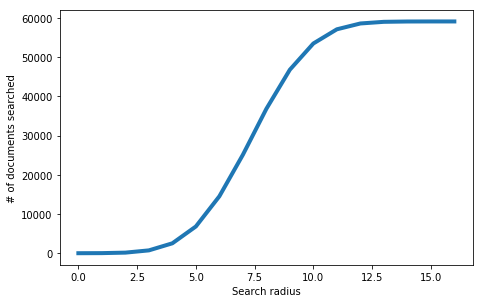

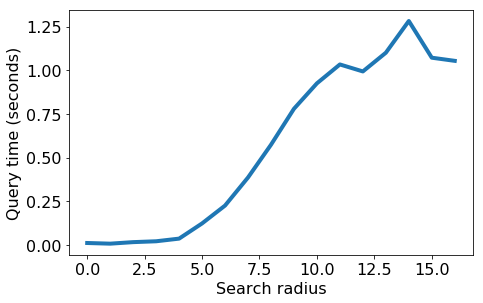

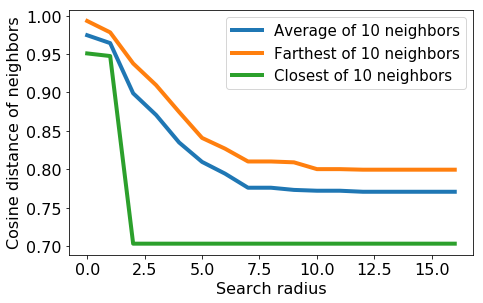

In [88]:
plt.figure(figsize=(7,4.5))
plt.plot(num_candidates_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('# of documents searched')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(query_time_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(average_distance_from_query_history, linewidth=4, label='Average of 10 neighbors')
plt.plot(max_distance_from_query_history, linewidth=4, label='Farthest of 10 neighbors')
plt.plot(min_distance_from_query_history, linewidth=4, label='Closest of 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance of neighbors')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

Some observations:

 *   As we increase the search radius, we find more neighbors that are a smaller distance away.
 *   With increased search radius comes a greater number documents that have to be searched. Query time is higher as a consequence.
 *   With sufficiently high search radius, the results of LSH begin to resemble the results of brute-force search.

# Question 4
Refer to the section "Effect of nearby bin search". What was the smallest search radius that yielded the correct nearest neighbor for Obama, namely Joe Biden?

* 2

# Question 5
Suppose our goal was to produce 10 approximate nearest neighbors whose average distance from the query document is within 0.01 of the average for the true 10 nearest neighbors. For Barack Obama, the true 10 nearest neighbors are on average about 0.77. What was the smallest search radius for Barack Obama that produced an average distance of 0.78 or better? 

In [90]:
for i, v in enumerate(average_distance_from_query_history):
    if v <= 0.78:
        print(i, v)

7 0.7759826058523336
8 0.7759826058523336
9 0.7731349875446499
10 0.772070052411731
11 0.772070052411731
12 0.7707191289494767
13 0.7707191289494767
14 0.7707191289494767
15 0.7707191289494767
16 0.7707191289494767
